In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from scipy import stats
from statsmodels.api import add_constant
from pandas.core import datetools
%matplotlib inline

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
month = {'JAN': 1, 'FEB':2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT':10, 'NOV': 11, 'DEC': 12}

In [3]:
# Import high frequency data

path =r'D:\data_raw' # Please put all .csv documents into one folder
company_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS', \
                           'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
                            'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM' ] # Input company name as a list
company_data = {} # Store company data as a dictionary: {company_name1: data1, company_name2: data2, ...}
for company in company_list:
    frame = pd.DataFrame()
    list_ = []
    allFiles = glob.glob(path + '/' +company +'_' + '*.csv')
    allFiles.reverse()
    #print (allFiles)
    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=None, header=0, usecols=[0,1], skiprows=[1,])
        list_.append(df)
    frame = pd.concat(list_)
    company_data[company] = frame
    company_data[company].index = pd.RangeIndex(len(company_data[company].index))

In [4]:
high_mom_daily_data = {}
list_big_data = []
for com in company_data.keys():
    list_temp = []
    date_idx = []
    high_mom_daily_data[com] = pd.DataFrame(columns = ['RDVar', 'RDSkew', 'RDKurt'])
    date_idx_s = np.array(company_data[com].loc[pd.isnull(company_data[com].Close), ].index)
    date_idx_e = np.append(date_idx_s[1:], company_data[com].shape[0])
    for i, j in zip(date_idx_s, date_idx_e):
        date = company_data[com]['Time Interval'][i][:9]
        d = date[:2]
        m = str(month[date[2:5]])
        y = date[5:]
        date_idx.append(d+'/'+m+'/'+y)
        log_r = np.log(company_data[com].Close[i+1: j]).diff().dropna()
        RDVar = np.sum(np.square(log_r))
        RDSkew = np.sqrt(len(log_r)) * np.sum(log_r**3) / RDVar**1.5
        RDKurt = len(log_r) * np.sum(log_r**4) / RDVar**2
        list_temp.append({'RDVar': RDVar, 'RDSkew': RDSkew, 'RDKurt': RDKurt})
    high_mom_daily_data[com] = high_mom_daily_data[com].append(list_temp)
    high_mom_daily_data[com].index = pd.to_datetime(date_idx, dayfirst=True)
    list_big_data.append(high_mom_daily_data[com])

In [5]:
big_data = pd.concat(list_big_data, axis = 1)
big_data.dropna(axis = 0, how = 'any', inplace = True)

In [6]:
for com in high_mom_daily_data.keys():
    index = company_list.index(com)
    high_mom_daily_data[com] = big_data.iloc[:, index : index+3]

In [8]:
# Import daily data

company_daily = {}
list_daily = []
for com in company_list:
    company_daily[com] = pd.read_excel('D:\\daily_data_xls\\'+com+'_daily.xlsx', index_col = 0, header = 0)
    list_drop = list(company_daily[com].columns.values[:-1])
    company_daily[com].drop(list_drop, axis = 1, inplace = True)
    list_daily.append(company_daily[com])
    
big_data_daily = pd.concat(list_daily, axis = 1)
big_data_daily.dropna(axis = 0, how = 'any', inplace = True)

    #idx = high_mom_daily_data[com].index
    #company_daily[com] = company_daily[com].loc[idx, ]
    #company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
    #company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()
    #company_daily[com].index = high_mom_daily_data['AAPL'].index

In [9]:
super_big_data = pd.concat([big_data, big_data_daily], axis = 1)
super_big_data.dropna(axis = 0, how = 'any', inplace = True)

In [141]:
for com in company_daily.keys():
    super_big_data[com+'_logr'] = company_daily[com].Daily_logr

In [143]:
super_big_data.to_csv('D:\\super_big_data.csv')

In [11]:
company_daily = {}
for com in high_mom_daily_data.keys():
    index = company_list.index(com)
    high_mom_daily_data[com] = super_big_data.iloc[:, index : index+3]
    company_daily[com] = pd.DataFrame(super_big_data.iloc[:, index+90])
    company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
    company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()

In [12]:
company_daily['AAPL'].shape

(1255, 3)

In [13]:
# Import DJIA daily
#DJIA = pd.read_csv('D:\daily_data\DJI_daily.csv', index_col = None, header = 0, usecols=[6])
#DJIA.index = high_mom_daily_data['AAPL'].index
#DJIA['daily_r'] = np.log(DJIA.iloc[:, 0]).diff()

In [14]:
# Delete two dates
#date_to_delete = [pd.Timestamp('13/08/2013'), pd.Timestamp('12/09/2016')]
#for com in high_mom_daily_data.keys():
#    if date_to_delete[0] in high_mom_daily_data[com].index:
  #      high_mom_daily_data[com].drop(date_to_delete[0], inplace = True)
    #if date_to_delete[0] in company_daily[com].index:
    #    company_daily[com].drop(date_to_delete[0], inplace = True)
    #if date_to_delete[0] in DJIA.index:
       # DJIA.drop(date_to_delete[0], inplace = True)
    #if date_to_delete[1] in high_mom_daily_data[com].index:
    #  high_mom_daily_data[com].drop(date_to_delete[1], inplace = True)
    #if date_to_delete[1] in company_daily[com].index:
     #   company_daily[com].drop(date_to_delete[1], inplace = True)
    #if date_to_delete[1] in DJIA.index:
     #   DJIA.drop(date_to_delete[1], inplace = True)

In [15]:
# Combine two dataframes
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com]['DR'] = company_daily[com].Daily_logr

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Save data
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com].to_csv('D:\\output_data\\'+com+'.csv')

In [17]:
# daily close price by company matrix
price_com_mat = pd.DataFrame(columns = company_list)
for com in company_list:
    price_com_mat[com] = company_daily[com].iloc[:,0]

In [18]:
price_com_mat.to_csv('D:\\output_data\\'+'price_com_mat'+'.csv')

In [19]:
# Construct weekly data (5 trading days a week)
weekly_data = {}
for com in high_mom_daily_data.keys():
    weekly_data[com] = pd.DataFrame()
    weekly_data[com]['WR'] = high_mom_daily_data[com]['DR'].rolling(5).sum()[4::5]
    weekly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com]['RDVar'].rolling(5).mean()[4::5])
    weekly_data[com]['RSkew'] = high_mom_daily_data[com]['RDSkew'].rolling(5).mean()[4::5]
    weekly_data[com]['RKurt'] = high_mom_daily_data[com]['RDKurt'].rolling(5).mean()[4::5]

In [20]:
#DJIA_weekly = DJIA['daily_r'].rolling(5).sum()[4::5]

In [21]:
#for com in weekly_data.keys():
    #print (weekly_data[com].shape)

In [22]:
# Split weekly data into train and test data
weekly_test_data = {}
for com in weekly_data.keys():
    weekly_test_data[com] = weekly_data[com][-50: ]
    weekly_data[com] = weekly_data[com][:-50]

In [24]:
#for com in weekly_data.keys():
    #print (com, weekly_data[com].shape)

In [25]:
total_week = weekly_data['AAPL'].shape[0]

In [26]:
total_week

201

In [27]:
# Cross sectional regression
company_beta_pval = pd.DataFrame(columns = ['vol_intercept', 'b_vol', 'vol_p_val', 'skew_intercept', 'b_skew', \
                                                                                   'skew_p_val','kurt_intercept','b_kurt', 'kurt_p_val'])
list_cbp = []
for i in range(200):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        date_index = weekly_data[com].index
        next_return.append(weekly_data[com].WR[date_index[i+1]])
        cur_vol.append(weekly_data[com].RVol[date_index[i]])
        cur_skew.append(weekly_data[com].RSkew[date_index[i]])
        cur_kurt.append(weekly_data[com].RKurt[date_index[i]])
    cur_vol = add_constant(cur_vol)
    cur_skew = add_constant(cur_skew)
    cur_kurt = add_constant(cur_kurt)
    lm_vol = sm.OLS(next_return, cur_vol).fit()
    lm_skew = sm.OLS(next_return, cur_skew).fit()
    lm_kurt = sm.OLS(next_return, cur_kurt).fit()
    
    list_cbp.append({'vol_intercept': lm_vol.params[0], 'b_vol': lm_vol.params[1], 'vol_p_val': lm_vol.pvalues[1], \
                                 'skew_intercept': lm_skew.params[0], 'b_skew': lm_skew.params[1], 'skew_p_val': lm_skew.pvalues[1],\
                                  'kurt_intercept': lm_kurt.params[0], 'b_kurt': lm_kurt.params[1], 'kurt_p_val': lm_kurt.pvalues[1]})
company_beta_pval = company_beta_pval.append(list_cbp)

In [28]:
# IC time series of vol, skew and kurt
weekly_IC = pd.DataFrame(columns = ['vol_Rank_IC', 'vol_pvalue','skew_Rank_IC', 'skew_pvalue', 'kurt_Rank_IC', 'kurt_pvalue'])
list_dict = []
for i in range(200):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        date_index = weekly_data[com].index
        next_return.append(weekly_data[com].WR[date_index[i+1]])
        cur_vol.append(weekly_data[com].RVol[date_index[i]])
        cur_skew.append(weekly_data[com].RSkew[date_index[i]])
        cur_kurt.append(weekly_data[com].RKurt[date_index[i]])
    
    vol_IC, vol_p = stats.spearmanr(cur_vol, next_return)
    skew_IC, skew_p = stats.spearmanr(cur_skew, next_return)
    kurt_IC, kurt_p = stats.spearmanr(cur_kurt, next_return)
    
    list_dict.append({'vol_Rank_IC': vol_IC, 'vol_pvalue': vol_p, 'skew_Rank_IC': skew_IC, 'skew_pvalue': skew_p, \
                              'kurt_Rank_IC': kurt_IC, 'kurt_pvalue': kurt_p}) 
weekly_IC = weekly_IC.append(list_dict)
weekly_IC.index = weekly_data['AAPL'].index[1:]

In [137]:
IC_mean = weekly_IC.mean()
std = weekly_IC.std()
IC_IR = IC_mean / std
IC_IR
print ('vol_Rank_IC: ', IC_IR[0], '\nskew_Rank_IC: ', IC_IR[2], '\nkurt_Rank_IC: ', IC_IR[4],)

vol_Rank_IC:  0.0329197743672 
skew_Rank_IC:  -0.0253348476752 
kurt_Rank_IC:  -0.0676706949367


Positive significant rate:  0.08 Negative significant rate:  0.06


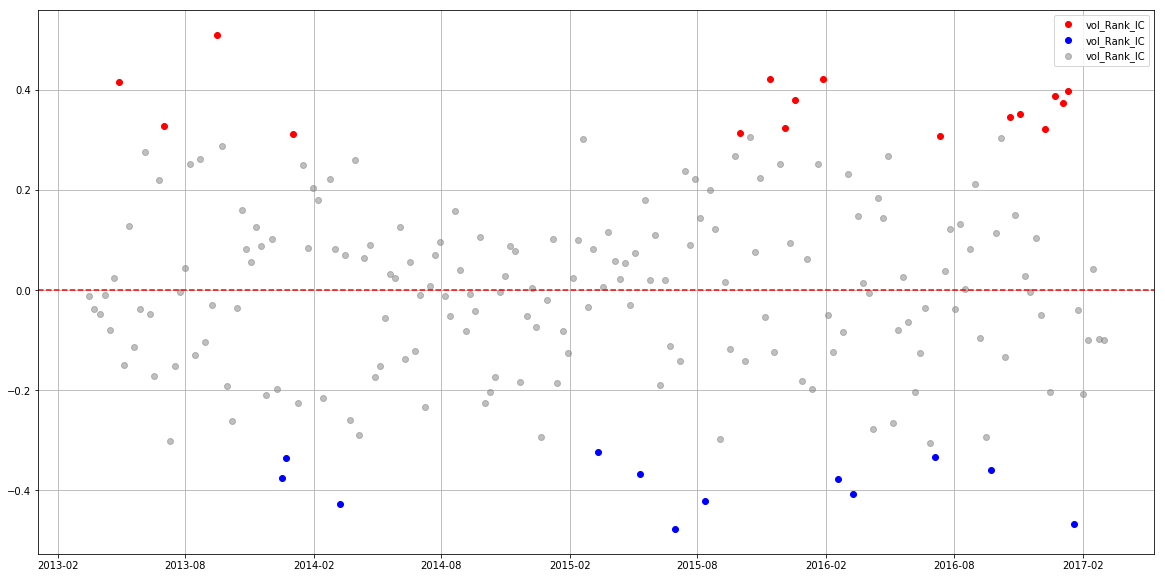

In [128]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.1) & (weekly_IC.vol_Rank_IC >= 0)].index
y11 = weekly_IC.vol_Rank_IC[x11]
x12 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.1) & (weekly_IC.vol_Rank_IC < 0)].index
y12 = weekly_IC.vol_Rank_IC[x12]
x2 = weekly_IC.vol_pvalue[weekly_IC.vol_pvalue >= 0.1].index
y2 = weekly_IC.vol_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(y11, 'o', color='red')
plt.plot(y12, 'o', color='blue')
plt.plot(y2, 'o', alpha=0.5, label='vol_Rank_IC', color='grey')
#plt.plot(range(200), [0 for i in range(200)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.06 Negative significant rate:  0.03


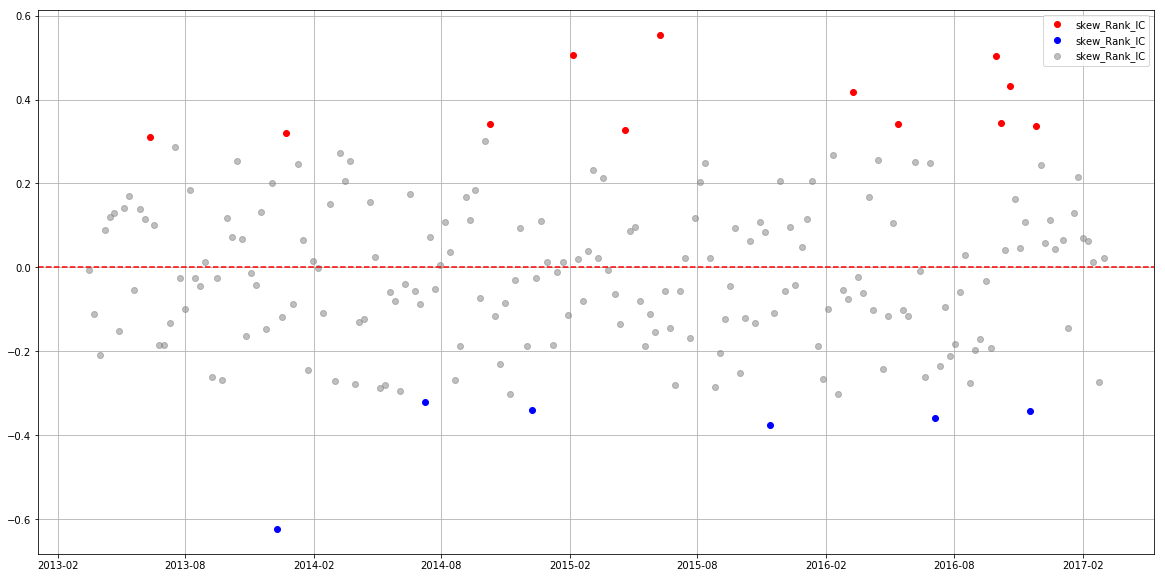

In [129]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.1) & (weekly_IC.skew_Rank_IC >= 0)].index
y11 = weekly_IC.skew_Rank_IC[x11]
x12 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.1) & (weekly_IC.skew_Rank_IC < 0)].index
y12 = weekly_IC.skew_Rank_IC[x12]
x2 = weekly_IC.skew_pvalue[weekly_IC.skew_pvalue >= 0.1].index
y2 = weekly_IC.skew_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(y11, 'o', color='red')
plt.plot(y12, 'o', color='blue')
plt.plot(y2, 'o', alpha=0.5, label='skew_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.06 Negative significant rate:  0.065


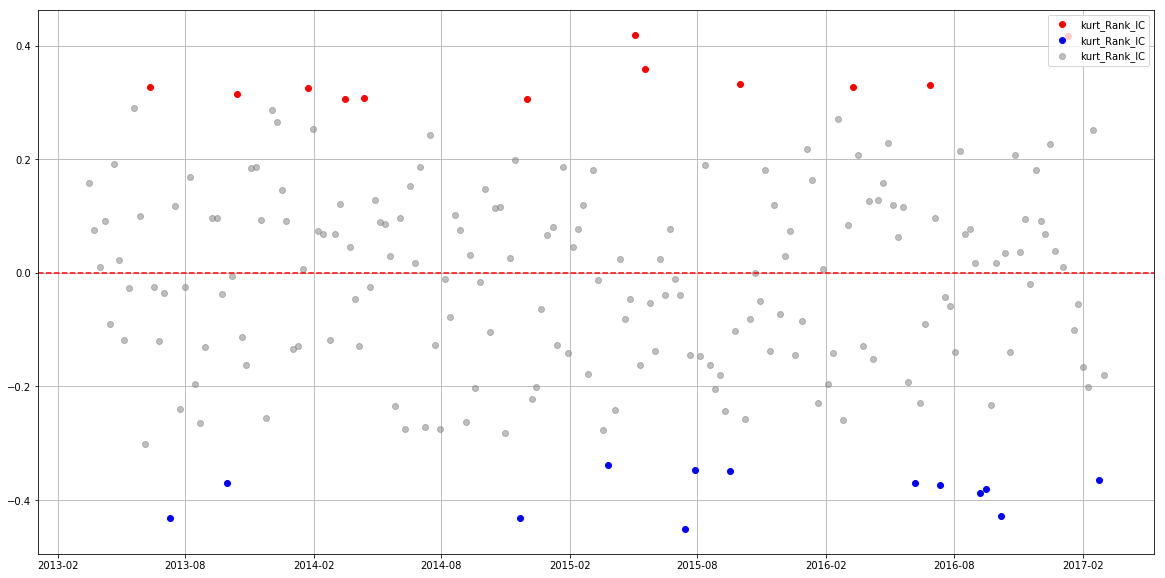

In [130]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.1) & (weekly_IC.kurt_Rank_IC >= 0)].index
y11 = weekly_IC.kurt_Rank_IC[x11]
x12 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.1) & (weekly_IC.kurt_Rank_IC < 0)].index
y12 = weekly_IC.kurt_Rank_IC[x12]
x2 = weekly_IC.kurt_pvalue[weekly_IC.kurt_pvalue >= 0.1].index
y2 = weekly_IC.kurt_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(x11, y11, 'o', color='red')
plt.plot(x12, y12, 'o', color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='kurt_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [34]:
# stocks having significant beta1_vol
company_beta_pval[['vol_intercept','b_vol','vol_p_val']][company_beta_pval.vol_p_val <0.05]

,vol_intercept,b_vol,vol_p_val
6,-0.098707,0.506457,0.015150
26,-0.025342,0.183342,0.049467
49,0.076629,-0.384577,0.034272
64,0.041546,-0.348393,0.042995
72,-0.021278,0.381762,0.027170
108,0.047008,-0.297159,0.020110
121,0.029443,-0.220118,0.020147
134,-0.052467,0.161272,0.037607
177,0.042844,-0.221597,0.032841
183,-0.050947,0.225621,0.023021


In [35]:
# stocks having significant beta1_skew
company_beta_pval[['skew_intercept','b_skew','skew_p_val']][company_beta_pval.skew_p_val <0.05]

,skew_intercept,b_skew,skew_p_val
15,0.001369,-0.022811,0.012904
37,0.000147,-0.037313,0.000697
39,0.035081,0.012966,0.039922
52,0.007355,-0.020430,0.012304
79,-0.023457,0.027844,0.033908
95,0.022033,0.074798,0.000257
112,-0.016669,0.024190,0.008055
178,-0.009505,0.027172,0.033073
179,0.005728,0.012842,0.037826


In [36]:
# Stocks having significant beta1_kurt
company_beta_pval[['kurt_intercept','b_kurt','kurt_p_val']][company_beta_pval.kurt_p_val <0.05]

,kurt_intercept,b_kurt,kurt_p_val
9,-0.032544,0.007907,0.029143
16,0.095760,-0.014050,0.005786
27,0.024241,-0.007289,0.029851
37,-0.052124,0.013169,0.028518
50,-0.027936,0.003537,0.040142
72,-0.008148,0.005920,0.031824
102,0.006799,-0.003958,0.022757
107,-0.046915,0.009274,0.006100
119,0.042006,-0.007815,0.009288
162,0.034121,-0.005132,0.030862


In [37]:
company_beta_pval.shape

(200, 9)

In [38]:
company_beta_pval.mean()

vol_intercept     0.001480
b_vol             0.005284
vol_p_val         0.468529
skew_intercept    0.002297
b_skew           -0.000175
skew_p_val        0.486634
kurt_intercept    0.003807
b_kurt           -0.000241
kurt_p_val        0.465589
dtype: float64

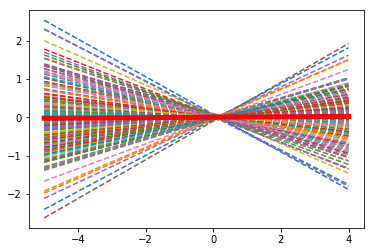

In [39]:
# Linear regression of return on vol
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.vol_intercept[row] + x*company_beta_pval.b_vol[row], '--')
plt.plot(x, company_beta_pval.vol_intercept.mean() + x*company_beta_pval.b_vol.mean(), color = 'red', lw = 5)
plt.show()

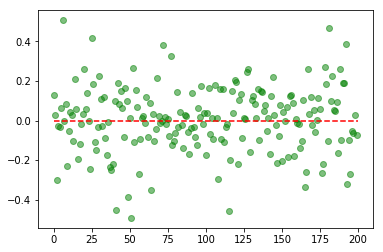

In [40]:
plt.plot(company_beta_pval.b_vol, 'o', alpha = 0.5, color = 'green')
plt.plot(range(201), [0 for i in range(201)], 'r--')

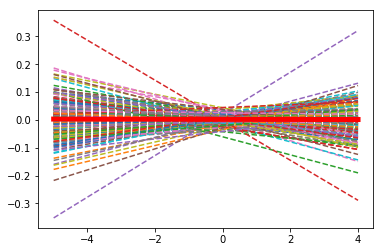

In [41]:
# Linear regression of return on skew
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.skew_intercept[row] + x*company_beta_pval.b_skew[row], '--')
plt.plot(x, company_beta_pval.skew_intercept.mean() + x*company_beta_pval.b_skew.mean(), color = 'red', lw = 5)
plt.show()

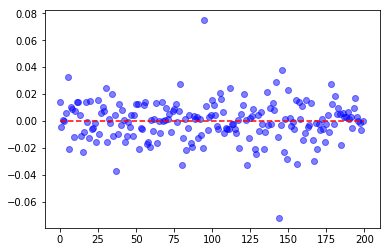

In [42]:
plt.plot(company_beta_pval.b_skew, 'o', alpha = 0.5, color = 'blue')
plt.plot(range(201), [0 for i in range(201)], 'r--')

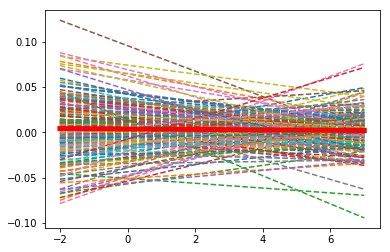

In [43]:
# Linear regression of return on kurt
x = np.arange(-2, 8)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.kurt_intercept[row] + x*company_beta_pval.b_kurt[row], '--')
plt.plot(x, company_beta_pval.kurt_intercept.mean() + x*company_beta_pval.b_kurt.mean(), color = 'red', lw = 5)
plt.show()

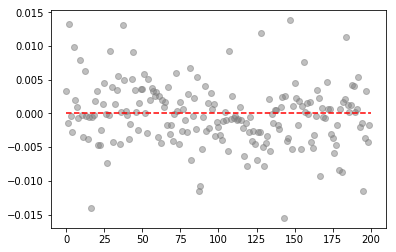

In [44]:
plt.plot(company_beta_pval.b_kurt, 'o', alpha = 0.5, color = 'grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')

In [81]:
# return_by_group_vol
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_vol = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    vol_this_week = sorted([(com, weekly_data[com].RVol[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*vol_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(weekly_data[com].WR[week+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_vol = return_by_group_vol.append(tmp_list)
return_by_group_vol.index = weekly_data['AAPL'].index[1:]

In [82]:
return_by_group_vol.sum()

group1    0.463052
group2    0.525849
group3    0.542173
dtype: float64

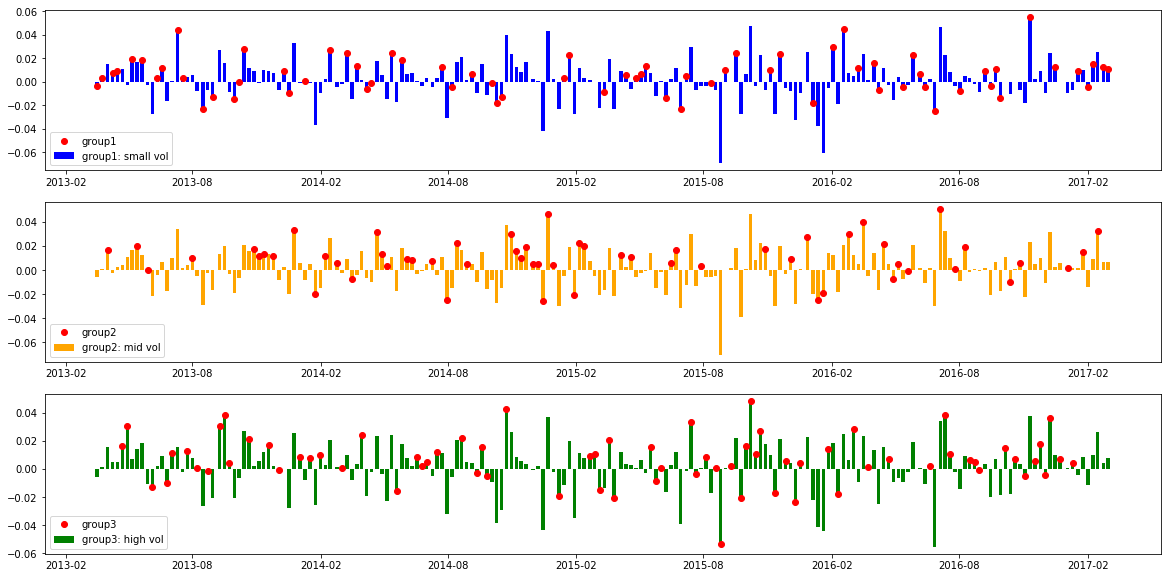

group1 win rate:  0.345 
 group2 win rate:  0.29 
 group3 win rate:  0.365


In [127]:
vol_max = return_by_group_vol.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_vol.group1.index, return_by_group_vol.group1, label = 'group1: small vol', width = 5, color = 'blue')
plt.plot(return_by_group_vol.group1[vol_max[vol_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_vol.group2.index, return_by_group_vol.group2, label = 'group2: mid vol', width = 5, color = 'orange')
plt.plot(return_by_group_vol.group2[vol_max[vol_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_vol.group3.index, return_by_group_vol.group3, label = 'group3: high vol', width = 5, color = 'green')
plt.plot(return_by_group_vol.group3[vol_max[vol_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(vol_max[vol_max == 'group1'])/float(len(vol_max)),'\n',\
       'group2 win rate: ', len(vol_max[vol_max == 'group2'])/float(len(vol_max)), '\n',\
       'group3 win rate: ', len(vol_max[vol_max == 'group3'])/float(len(vol_max)))

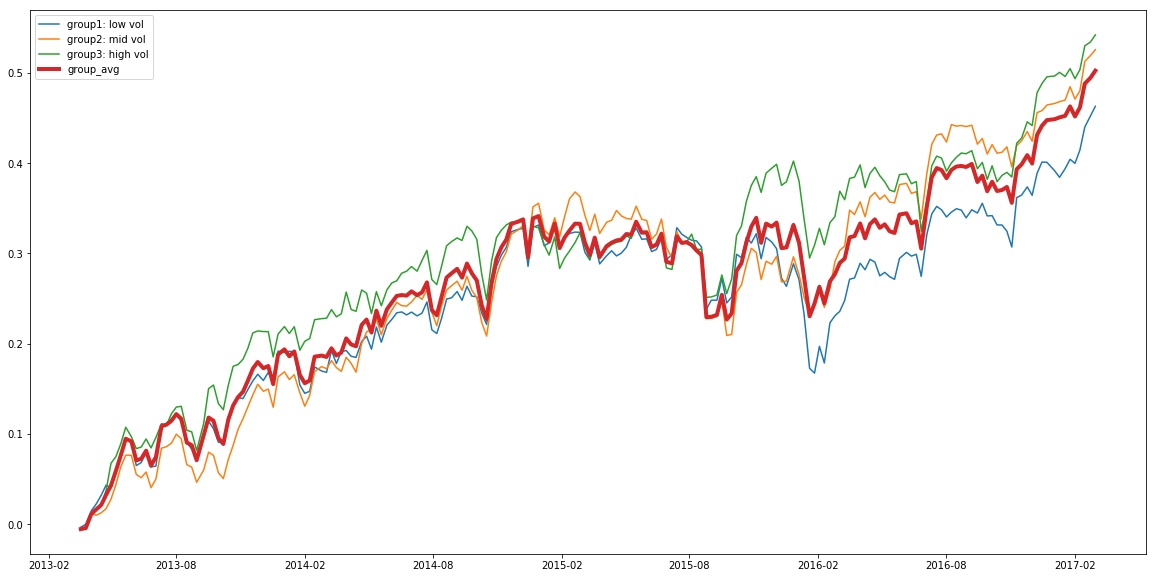

In [85]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_vol.group1.index, return_by_group_vol.group1.cumsum(), label = 'group1: low vol')
plt.plot(return_by_group_vol.group2.index, return_by_group_vol.group2.cumsum(), label = 'group2: mid vol')
plt.plot(return_by_group_vol.group3.index, return_by_group_vol.group3.cumsum(), label = 'group3: high vol')
#return_by_group_vol['market'] = (return_by_group_vol.group1 + return_by_group_vol.group2 + return_by_group_vol.group3)/3
plt.plot(return_by_group_vol.median(axis=1).cumsum(), label = 'group_avg', lw = 4)
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

In [74]:
# return_by_group_skew
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_skew = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    skew_this_week = sorted([(com, weekly_data[com].RSkew[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*skew_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(weekly_data[com].WR[week+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_skew = return_by_group_skew.append(tmp_list)
return_by_group_skew.index = weekly_data['AAPL'].index[1:]

In [75]:
return_by_group_skew.sum()

group1    0.549886
group2    0.526674
group3    0.412322
dtype: float64

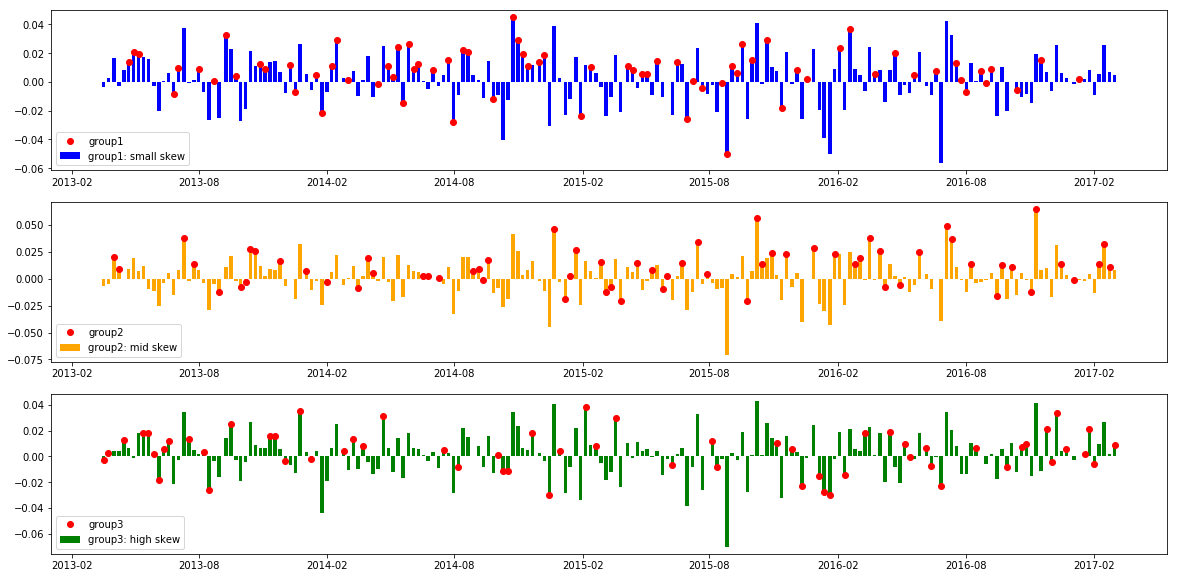

group1 win rate:  0.37 
 group2 win rate:  0.32 
 group3 win rate:  0.31


In [126]:
skew_max = return_by_group_skew.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_skew.group1.index, return_by_group_skew.group1, label = 'group1: small skew', width = 5, color = 'blue')
plt.plot(return_by_group_skew.group1[skew_max[skew_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_skew.group2.index, return_by_group_skew.group2, label = 'group2: mid skew', width = 5, color = 'orange')
plt.plot(return_by_group_skew.group2[skew_max[skew_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_skew.group3.index, return_by_group_skew.group3, label = 'group3: high skew', width = 5, color = 'green')
plt.plot(return_by_group_skew.group3[skew_max[skew_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(skew_max[skew_max == 'group1'])/float(len(skew_max)),'\n',\
       'group2 win rate: ', len(skew_max[skew_max == 'group2'])/float(len(skew_max)), '\n',\
       'group3 win rate: ', len(skew_max[skew_max == 'group3'])/float(len(skew_max)))

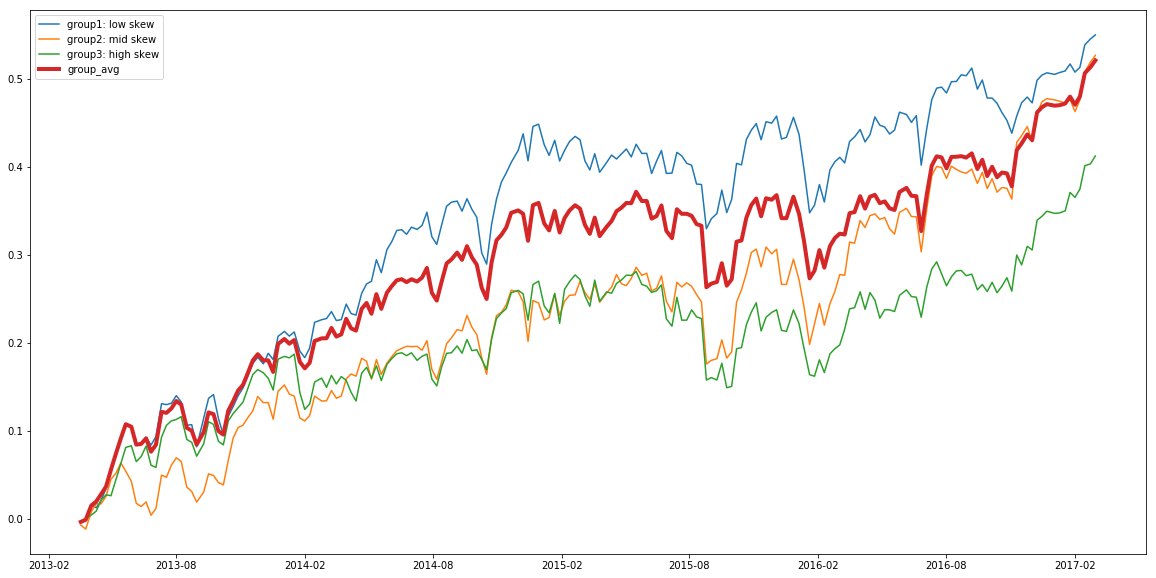

In [80]:
plt.figure(figsize = (20,10))
plt.plot(return_by_group_skew.group1.index, return_by_group_skew.group1.cumsum(), label = 'group1: low skew')
plt.plot(return_by_group_skew.group2.index, return_by_group_skew.group2.cumsum(), label = 'group2: mid skew')
plt.plot(return_by_group_skew.group3.index, return_by_group_skew.group3.cumsum(), label = 'group3: high skew')
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
#return_by_group_skew['market'] = return_by_group_skew
plt.plot(return_by_group_skew.median(axis = 1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

In [86]:
# return_by_group_kurt
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_kurt = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    kurt_this_week = sorted([(com, weekly_data[com].RKurt[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*kurt_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(weekly_data[com].WR[week+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_kurt = return_by_group_kurt.append(tmp_list)
return_by_group_kurt.index = weekly_data['AAPL'].index[1:]

In [87]:
return_by_group_kurt.sum()

group1    0.403805
group2    0.601349
group3    0.461860
dtype: float64

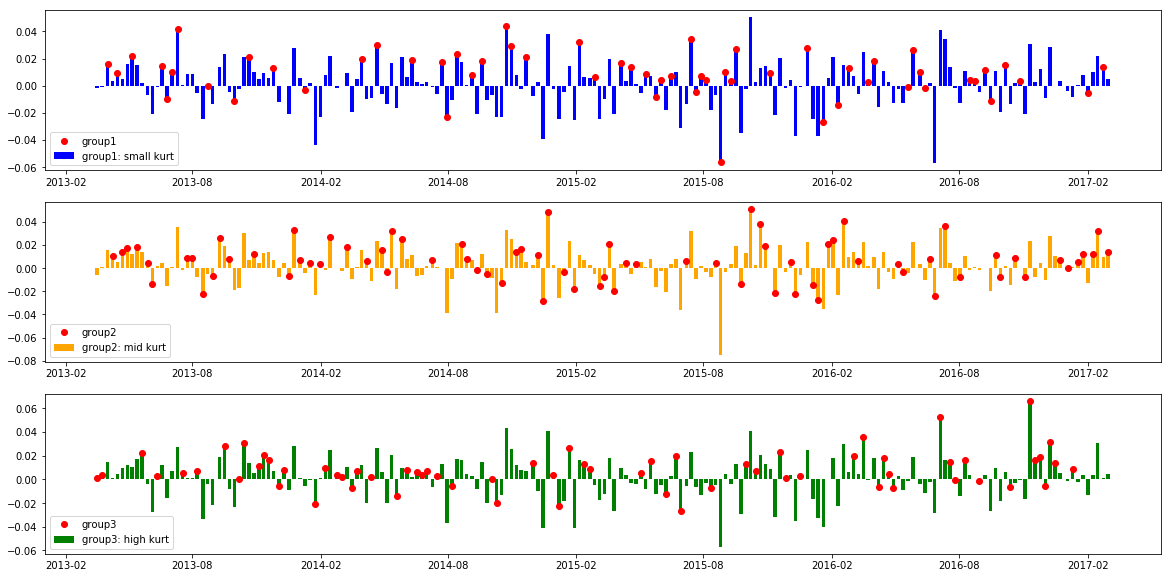

group1 win rate:  0.29 
 group2 win rate:  0.38 
 group3 win rate:  0.33


In [125]:
kurt_max = return_by_group_kurt.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_kurt.group1.index, return_by_group_kurt.group1, label = 'group1: small kurt', width = 5, color = 'blue')
plt.plot(return_by_group_kurt.group1[kurt_max[kurt_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_kurt.group2.index, return_by_group_kurt.group2, label = 'group2: mid kurt', width = 5, color = 'orange')
plt.plot(return_by_group_kurt.group2[kurt_max[kurt_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_kurt.group3.index, return_by_group_kurt.group3, label = 'group3: high kurt', width = 5, color = 'green')
plt.plot(return_by_group_kurt.group3[kurt_max[kurt_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(kurt_max[kurt_max == 'group1'])/float(len(kurt_max)),'\n',\
       'group2 win rate: ', len(kurt_max[kurt_max == 'group2'])/float(len(kurt_max)), '\n',\
       'group3 win rate: ', len(kurt_max[kurt_max == 'group3'])/float(len(kurt_max)))

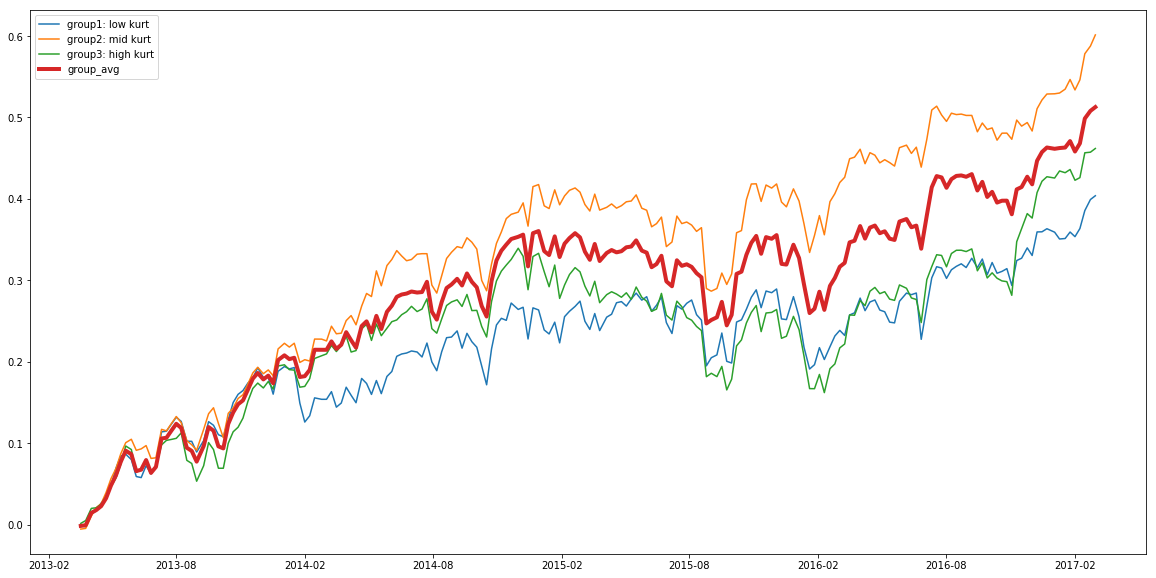

In [90]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_kurt.group1.cumsum(), label = 'group1: low kurt')
plt.plot(return_by_group_kurt.group2.cumsum(), label = 'group2: mid kurt')
plt.plot(return_by_group_kurt.group3.cumsum(), label = 'group3: high kurt')
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
#return_by_group_kurt['market'] = (return_by_group_kurt.group1 + return_by_group_kurt.group2 + return_by_group_kurt.group3)/3
plt.plot(return_by_group_kurt.median(axis = 1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')